In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import wav2clip
import torch
import torch.nn as nn

In [2]:
def preprocess_dataframe(dataframe):
    dataframe = dataframe[0].str.split(' ', expand=True)
    dataframe.columns = ['music_id', 'image_id', 'matching']
    dataframe['matching'] = dataframe['matching'].astype(float)
    dataframe = dataframe.where(dataframe['matching'] > 0.5).dropna()
    dataframe = dataframe.where(dataframe['image_id'].str.contains('COCO')).dropna()
    dataframe = dataframe.reset_index(drop=True)
    return dataframe

train_data = preprocess_dataframe(pd.read_csv('data/train_matching.txt', sep='\t', header=None))
val_data = preprocess_dataframe(pd.read_csv('data/val_matching.txt', sep='\t', header=None))
test_data = preprocess_dataframe(pd.read_csv('data/test_matching.txt', sep='\t', header=None))

print(f'Train data: {len(train_data)}\nValidation data: {len(val_data)}\nTest data: {len(test_data)}')

Train data: 29696
Validation data: 2273
Test data: 7249


Similarity: 0.5888041897687166


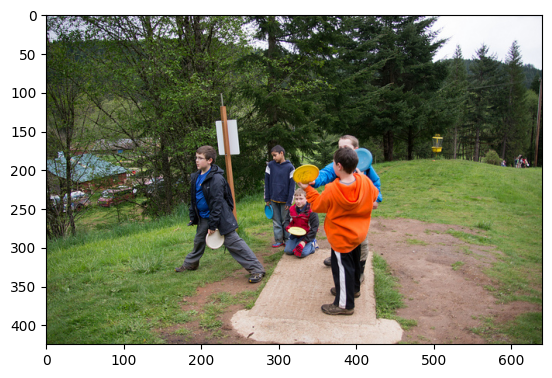

In [3]:
import IPython.display as ipd

def show_music_image(index):
    music_id = train_data.iloc[index]['music_id']
    image_id = train_data.iloc[index]['image_id']
    music_path = 'data/music/' + music_id + '.wav'
    image_path = 'data/images/' + image_id + '.jpg'

    music = ipd.Audio(music_path)
    image = plt.imread(image_path) 

    print(f'Similarity: {train_data.iloc[index]["matching"]}')
    ipd.display(music)
    plt.imshow(image)

index = np.random.randint(0, len(train_data))
show_music_image(index)

In [4]:
from torch.utils.data import DataLoader
from src.music2ImageDataset import MusicImageDataset

IMAGE_PATH = 'data/images/'
MUSIC_PATH = 'data/music/'
IMAGE_SIZE = 64
BATCH_SIZE = 32

train_dataset = MusicImageDataset(train_data)
val_dataset = MusicImageDataset(val_data)
test_dataset = MusicImageDataset(test_data)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

In [9]:
from src.GAN import Music2ImageGenerator
from src.GAN import FakeImageDiscriminator

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Music2ImageGenerator().to(device)
discriminator = FakeImageDiscriminator().to(device)

In [10]:
for music, image in val_loader:
    music = music.to(device)
    image = image.to(device)
    print(music.size(), image.size())
    z = torch.randn(music.size(0), 512).to(device)
    fake_image = generator(z, music)
    print(fake_image.size())
    out = discriminator(fake_image)
    print(out)
    break

torch.Size([32, 512]) torch.Size([32, 3, 64, 64])
torch.Size([32, 3, 64, 64])
tensor([[0.5462],
        [0.6640],
        [0.4865],
        [0.6581],
        [0.5858],
        [0.6394],
        [0.4995],
        [0.5854],
        [0.4297],
        [0.7168],
        [0.5588],
        [0.7610],
        [0.5749],
        [0.7460],
        [0.7499],
        [0.6810],
        [0.7932],
        [0.6208],
        [0.6567],
        [0.9069],
        [0.8496],
        [0.5012],
        [0.7326],
        [0.5453],
        [0.7350],
        [0.6853],
        [0.7459],
        [0.7325],
        [0.7350],
        [0.7008],
        [0.6607],
        [0.5035]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [11]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=2e-5)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=2e-5)
criterion = nn.BCELoss()

real_label = torch.FloatTensor(BATCH_SIZE).uniform_(0.9, 1).to(device).reshape(-1, 1)
fake_label = torch.FloatTensor(BATCH_SIZE).uniform_(0, 0.1).to(device).reshape(-1, 1)

In [14]:
from src.model_train import train
from src.model_test import evaluate
EPOCHS = 100
best_val_score = 1e9

for epoch in range(EPOCHS):
    train(epoch, train_loader, generator, discriminator, optimizer_G, optimizer_D, criterion, device, real_label, fake_label)
    val_score = evaluate(epoch, val_loader, generator, discriminator, criterion, device, real_label, fake_label)
    if val_score[0] < best_val_score:
        best_val_score = val_score[0]
        torch.save(generator.state_dict(), 'models/best_generator.pth')
        torch.save(discriminator.state_dict(), 'models/best_discriminator.pth')

Epoch 0, Generator Loss: 3.70060, Discriminator Loss: 0.58428, Discriminator Accuracy: 0.99431: 100%|██████████| 928/928 [01:04<00:00, 14.41it/s]
	Validation Epoch 0, Generator Loss: 0.32467, Discriminator Loss: 4.73069, Discriminator Accuracy: 0.02597: 100%|██████████| 71/71 [00:01<00:00, 40.42it/s]
Epoch 1, Generator Loss: 2.86053, Discriminator Loss: 0.44259, Discriminator Accuracy: 1.00000: 100%|██████████| 928/928 [01:05<00:00, 14.26it/s]
	Validation Epoch 1, Generator Loss: 0.24323, Discriminator Loss: 2.61193, Discriminator Accuracy: 0.74604: 100%|██████████| 71/71 [00:01<00:00, 39.86it/s]
Epoch 2, Generator Loss: 2.77919, Discriminator Loss: 0.43740, Discriminator Accuracy: 1.00000: 100%|██████████| 928/928 [01:05<00:00, 14.16it/s]
	Validation Epoch 2, Generator Loss: 0.24042, Discriminator Loss: 2.68871, Discriminator Accuracy: 0.71875: 100%|██████████| 71/71 [00:01<00:00, 39.79it/s]
Epoch 3, Generator Loss: 2.75510, Discriminator Loss: 0.43582, Discriminator Accuracy: 1.00000

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


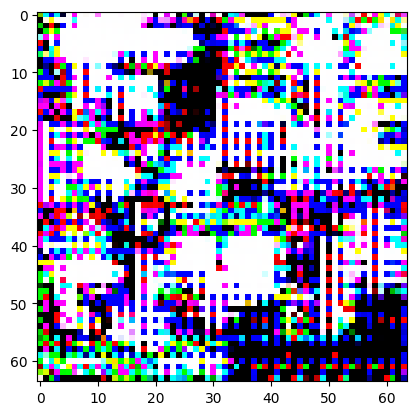

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


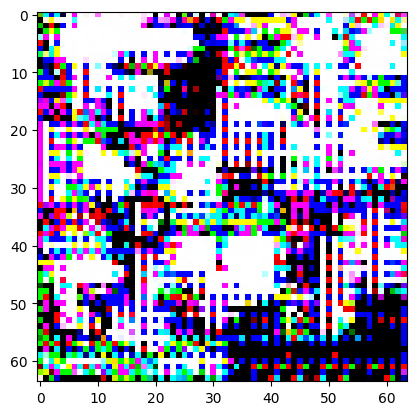

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


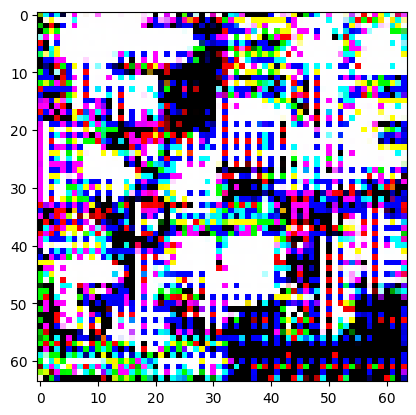

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


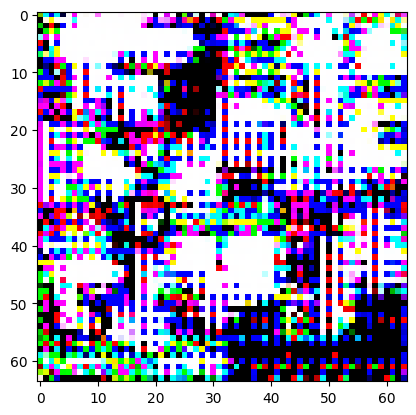

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


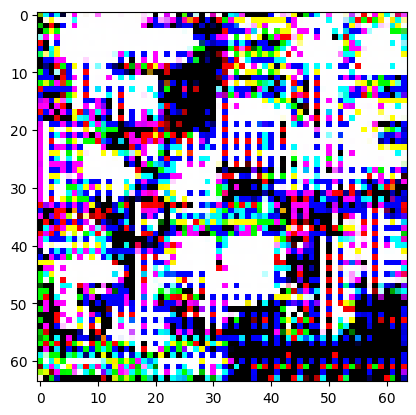

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


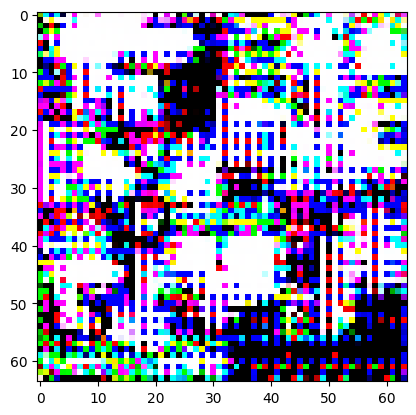

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


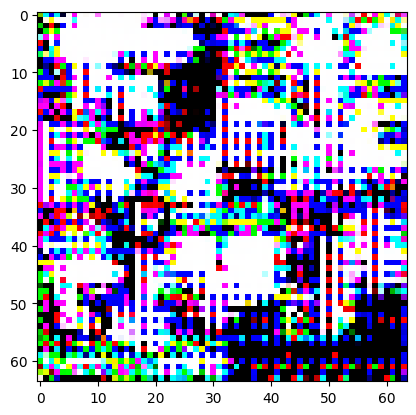

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


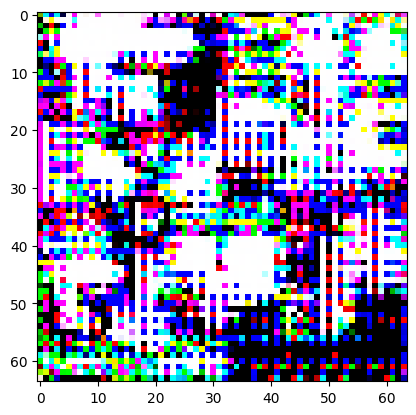

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


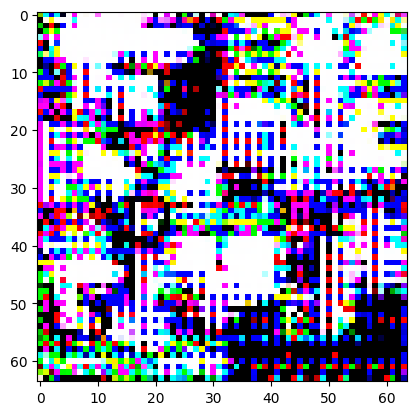

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


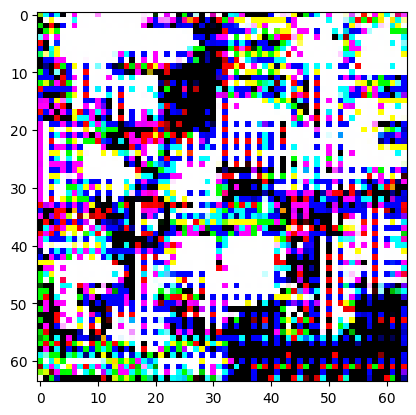

In [15]:
j = 0
for music, image in train_loader:
    if j == 10:
        music = music.to(device)
        image = image.to(device)
        z = torch.randn(music.size(0), 512).to(device)
        fake_image = generator(z, music).permute(0, 2, 3, 1).cpu().detach().numpy()
        for i in range(10):
            plt.imshow(fake_image[i])
            plt.show()
        break
    j += 1